# hand-sign recognizer
Here we build a convolutional neural-network for recognizing hand-signs.

> Inspired by: [Convolutional Neural Networks](https://www.coursera.org/learn/convolutional-neural-networks)

In [1]:
import torch
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn

from collections import OrderedDict
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import math
import util

import sys, os, importlib
sys.path.append(os.path.join("..", "data"))

from loaders import hand_signs
_ = importlib.reload(hand_signs)
_ = importlib.reload(util)

## # loading and pre-processing data

In [2]:
one_hot_transform = Lambda(lambda y: torch.zeros(6, dtype=torch.float)\
    .scatter_(dim=0, index=y, value=1))
train_data = hand_signs.HandSigns(train=True)
norm_transform = train_data.get_norm_transform()
test_data = hand_signs.HandSigns(train=False, transform=norm_transform)
class_labels = train_data.get_class_labels()

print(f"# of training-examples: {len(train_data)}")
print(f"# of test-examples: {len(test_data)}")
# [3] -> (image, label) pair at idx-3, [0] -> image
print(f"image-dimensions: {train_data[3][0].shape}")
print(f"class-labels: {len(class_labels)}")

# of training-examples: 1080
# of test-examples: 120
image-dimensions: torch.Size([3, 64, 64])
class-labels: 6


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## # architecture
We will use a 3-layer CNN, as defined below:

<center>

| #-layer | layer-type      | component        | properties                           |         |
|---------|-----------------|------------------|--------------------------------------|---------|
| 1       | 2d-convolution  | kernel           | $(h^{[1]}_k, w^{[1]}_k)$             | $(4,4)$ |
|         |                 | #-kernels        | $c^{[1]}$                            | 8       |
|         |                 | convolve-pding | $(h^{[1]}_p, w^{[1]}_p)$             |`<same>` |
|         |                 | convolve-stride  | $(h^{[1]}_s, w^{[1]}_s)$             | $(1,1)$ |
|         |                 | pooling          | max-pooling                          |         |
|         |                 | pooling-filter   | $(h^{[1]}_l, w^{[1]}_l)$             | $(8,8)$ |
|         |                 | pooling-padding  | $({}^{l}h^{[1]}_p, {}^{l}w^{[1]}_p)$ |`<same>` |
|         |                 | pooling-stride   | $({}^{l}h^{[1]}_s, {}^{l}w^{[1]}_s)$ | $(8,8)$ |
|         |                 | activation       | ReLU                                 |         |
| 2       | 2d-convolution  | kernel           | $(h^{[2]}_k, w^{[2]}_k)$             | $(2,2)$ |
|         |                 | #-kernels        | $c^{[2]}$                            | 16      |
|         |                 | convolve-padding | $(h^{[2]}_p, w^{[2]}_p)$             |`<same>` |
|         |                 | convolve-stride  | $(h^{[2]}_s, w^{[2]}_s)$             | $(1,1)$ |
|         |                 | pooling          | max-pooling                          |         |
|         |                 | pooling-filter   | $(h^{[2]}_l, w^{[2]}_l)$             | $(4,4)$ |
|         |                 | pooling-padding  | $({}^{l}h^{[2]}_p, {}^{l}w^{[2]}_p)$ |`<same>` |
|         |                 | pooling-stride   | $({}^{l}h^{[2]}_s, {}^{l}w^{[2]}_s)$ | $(4,4)$ |
|         |                 | activation       | ReLU                                 |         |
| 3       | fully-connected | #-neurons        | $n^{[3]}$                            | $6$     |
|         |                 | activation       | softmax                              |         |

</center>

Also, the number of channels in the input, i.e. $c^{[0]} = 3$.

* Given the stride and kernel, `<same>` padding refers to the padding regime wherein the output immediately after the convolution is of the same size as that of the input, i.e.
$$
h^{[l]}_z = \left\lfloor\frac{h^{[l]}_a + 2h^{[l]}_p - h^{[l]}_k}{h^{[l]}_s} + 1\right\rfloor = h^{[l]}_a;\qquad w^{[l]}_z = \left\lfloor\frac{w^{[l]}_a + 2w^{[l]}_p - w^{[l]}_k}{w^{[l]}_s} + 1\right\rfloor = w^{[l]}_a
$$

## # forward-propagation
> **Note**: for the forward-propagation equations, read [Section-2, Back-propagation: Conv2D](./back-propagation_Conv2D.pdf).

In [4]:
def get_activation_module(func_name: str, **kwargs) -> nn.Module:
    if func_name == 'relu':
        return nn.ReLU(**kwargs)
    elif func_name == 'log-softmax':
        return nn.LogSoftmax(**kwargs)
    else:
        raise ValueError(f"Unknown activation-function: {func_name}")

class HandSignRecognizer(nn.Module):
    def __init__(self, model_arch: dict):
        super(HandSignRecognizer, self).__init__()
        
        self.model_arch = model_arch
        self.modules = OrderedDict()
        L = model_arch["L"] # layer-count

        for l in np.arange(start=1, stop=L+1, step=1):
            layer_mod = OrderedDict()
            if self.model_arch["t-l" + str(l)] == 'conv':
                layer_mod.update([
                    ("conv-l" + str(l), torch.nn.utils.skip_init(nn.Conv2d,
                        in_channels=self.model_arch["c-l" + str(l-1)],
                        out_channels=self.model_arch["c-l" + str(l)],
                        kernel_size=self.model_arch["k-l" + str(l)],
                        stride=self.model_arch["s-l" + str(l)],
                        padding=self.model_arch["p-l" + str(l)],
                        bias=True)),
                    ("act-l" + str(l), get_activation_module(
                        func_name=self.model_arch["g-l" + str(l)],
                        **self.model_arch['param-g-l' + str(l)]))
                ])
                nn.init.xavier_normal_(layer_mod["conv-l" + str(l)].weight)
                nn.init.zeros_(layer_mod["conv-l" + str(l)].bias)

                # value -> (h_p^{l}, w_p^{l})
                model_arch["_p-l" + str(l)] = util.compute_padding(
                    p_template=self.model_arch["p-l" + str(l)],
                    a_shape=self.model_arch["_a-l" + str(l-1)],
                    k_shape=self.model_arch["k-l" + str(l)],
                    s_shape=self.model_arch["s-l" + str(l)])

                # value -> (h_i^{l}, w_i^{l})
                model_arch["_i-l" + str(l)] = util.convolved_size(
                    a_shape=self.model_arch["_a-l" + str(l-1)],
                    k_shape=self.model_arch["k-l" + str(l)],
                    p_shape=self.model_arch["_p-l" + str(l)],
                    s_shape=self.model_arch["s-l" + str(l)])

                # value -> ({pool}^h_p^{l}, {pool}^w_p^{l})
                model_arch["_pl-p-l" + str(l)] = util.compute_padding(
                    p_template=self.model_arch["pl-p-l" + str(l)],
                    a_shape=self.model_arch["_i-l" + str(l)],
                    k_shape=self.model_arch["pl-k-l" + str(l)],
                    s_shape=self.model_arch["pl-s-l" + str(l)])

                # value -> (h_a^{l}, w_a^{l})
                model_arch["_a-l" + str(l)] = util.convolved_size(
                    a_shape=self.model_arch["_i-l" + str(l)],
                    k_shape=self.model_arch["pl-k-l" + str(l)],
                    p_shape=self.model_arch["_pl-p-l" + str(l)],
                    s_shape=self.model_arch["pl-s-l" + str(l)])

                if model_arch["pl-t-l" + str(l)] == 'max':
                    pad = model_arch["_pl-p-l" + str(l)]
                    layer_mod['pool-pad-l' + str(l)] = nn.ZeroPad2d(
                        padding=(pad[1], pad[1], pad[0], pad[0]))
                    layer_mod['pool-l' + str(l)] = nn.MaxPool2d(
                        kernel_size=self.model_arch["pl-k-l" + str(l)],
                        padding=0,
                        stride=self.model_arch["pl-s-l" + str(l)])
                else:
                    raise ValueError(
                        f"Invalid pooling type: {model_arch['pl-t-l' + str(l)]}")

            elif self.model_arch["t-l" + str(l)] == 'flat':
                if self.model_arch["t-l" + str(l-1)] == 'conv':
                    a_l_1 = self.model_arch["_a-l" + str(l-1)]
                    c_l_1 = self.model_arch["c-l" + str(l-1)]
                    in_features = a_l_1[0] * a_l_1[1] * c_l_1

                    # flattens elements row-wise and for all channels, in each example
                    layer_mod['flatten'] = nn.Flatten()
                elif self.model_arch["t-l" + str(l-1)] == 'flat':
                    in_features = self.model_arch["n-l" + str(l-1)]
                else:
                    raise ValueError(
                        f"Invalid layer-type: {self.model_arch['t-l' + str(l-1)]}")

                layer_mod.update([
                    ("lin-l" + str(l), nn.utils.skip_init(nn.Linear,
                        in_features=in_features,
                        out_features=self.model_arch['n-l' + str(l)],
                        bias=True)),
                    ("act-l" + str(l), get_activation_module(
                        func_name=self.model_arch["g-l" + str(l)],
                        **self.model_arch['param-g-l' + str(l)]))
                ])
                nn.init.xavier_normal_(layer_mod["lin-l" + str(l)].weight)
                nn.init.zeros_(layer_mod["lin-l" + str(l)].bias)

            self.modules.update(layer_mod) # inplace updation

        # initializing the network
        self.network = nn.Sequential(self.modules)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [5]:
model_arch = {
    "L": 3,

    "t-l0": "conv", # the input is similar to the output of a convolutional layer
    "c-l0": train_data[5][0].shape[0],
    "_a-l0": train_data[5][0].shape[1:],

    "t-l1": "conv",
    "k-l1": (4,4),
    "c-l1": 8,
    "p-l1": 'same', # -1 demotes same-padding in that dimension
    "s-l1": (1,1),
    "pl-t-l1": "max",
    "pl-k-l1": (8,8),
    "pl-p-l1": 'same',
    "pl-s-l1": (8,8),
    "g-l1": "relu",
    "param-g-l1": {},

    "t-l2": "conv",
    "k-l2": (2,2),
    "c-l2": 16,
    "p-l2": 'same',
    "s-l2": (1,1),
    "pl-t-l2": "max",
    "pl-k-l2": (4,4),
    "pl-p-l2": 'same',
    "pl-s-l2": (4,4),
    "g-l2": "relu",
    "param-g-l2": {},

    "t-l3": "flat",
    "n-l3": 6,
    "g-l3": "log-softmax",
    "param-g-l3": {
        'dim': 1
    }
}

model = HandSignRecognizer(model_arch=model_arch)
model.to(device)
print(model)

HandSignRecognizer(
  (network): Sequential(
    (conv-l1): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (act-l1): ReLU()
    (pool-pad-l1): ZeroPad2d((224, 224, 224, 224))
    (pool-l1): MaxPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0, dilation=1, ceil_mode=False)
    (conv-l2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (act-l2): ReLU()
    (pool-pad-l2): ZeroPad2d((96, 96, 96, 96))
    (pool-l2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (lin-l3): Linear(in_features=65536, out_features=6, bias=True)
    (act-l3): LogSoftmax(dim=1)
  )
)


## # backward-propagation
> **Note**: for the backward-propagation diagram, equations, and their derivation, read [Section-3.1, Back-propagation: Conv2D](./back-propagation_Conv2D.pdf).
>
>For the derivation of $\frac{\mathrm{d}J}{\mathrm{d}\mathbf{A}^{[3]}}$, and the derivation of $\frac{\mathrm{d}\mathbf{A}^{[3]}}{\mathrm{d}\mathbf{Z}^{[3]}}$, when $\mathbf{A}^{[3]} = \mathrm{softmax}(\mathbf{Z}^{[3]})$; see the section titled `backward-propagation` in [`..\1_multi_layer_perceptrons\hand-sign-recognizer.ipynb`](../1_multi_layer_perceptrons/hand-sign-recognizer.ipynb)
>

In [8]:
def evaluate_model(model: nn.Module, loss_func: nn.Module, test_data: Dataset, batch_size: int):
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
    
    total_test_loss: float = 0
    test_correct_count: int = 0
    
    with torch.no_grad():
        model.eval() # set model in evaluation mode

        for batch, (Xb, Yb) in enumerate(test_loader):
            # movie them to CUDA if device == 'cuda'
            Xb, Yb = Xb.to(device), Yb.to(device)

            pred = model(Xb)
            loss = loss_func(pred, Yb)

            total_test_loss += loss.item() * len(Xb)
            test_correct_count += (torch.argmax(pred, dim=1) == Yb).sum().item()
    
    return total_test_loss / len(test_data), test_correct_count / len(test_data)

def visualize_training(train_accuracies: list, train_losses: list, 
        test_accuracies: list, test_losses: list):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(30,15))

    ax1 = axs[0]
    ax1.plot(np.array(train_accuracies) * 100, label="train-accuracy")
    ax1.plot(np.array(test_accuracies) * 100, label="test-accuracy")
    ax1.set_ylabel('accuracy -->')
    ax1.set_xlabel('epoch -->')
    ax1.legend()

    ax2 = axs[1]
    ax2.plot(train_losses, label="train-loss")
    ax2.plot(test_losses, label="test-loss")
    ax2.set_ylabel('loss -->')
    ax2.set_xlabel('epoch -->')
    ax2.legend()

    plt.show()

def learn_model(train_data: Dataset, test_data: Dataset, model: nn.Module, 
        learning_rate: np.double, beta1: np.double, beta2: np.double, 
        epsilon: np.double, num_epochs: int, batch_size: int):

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    loss_func = nn.NLLLoss(reduction='mean') # compute the mean of the loss
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, 
        betas=[beta1, beta2], eps=epsilon)

    train_losses = list()
    train_accuracies = list()
    test_losses = list()
    test_accuracies = list()

    for e in tqdm(np.arange(start=0,stop=num_epochs,step=1)):
        total_train_loss: float = 0
        train_correct_count: int = 0

        model.train(mode=True) # set model in training mode
        for batch, (Xb, Yb) in enumerate(train_loader):
            # move them to CUDA if device == 'cuda'
            Xb, Yb = Xb.to(device), Yb.to(device)

            pred = model(Xb)
            loss = loss_func(pred, Yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # for debuggin
            total_train_loss += loss.item() * len(Xb)
            train_correct_count += (torch.argmax(pred, dim=1) == Yb).sum().item()

        train_losses.append(total_train_loss / len(train_data))
        train_accuracies.append(train_correct_count / len(train_data))

        test_loss, test_accuracy = evaluate_model(model=model, 
            test_data=test_data, loss_func=loss_func, batch_size=batch_size)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    
    return model, train_losses, train_accuracies, test_losses, test_accuracies

## # training-model

  0%|          | 0/100 [00:00<?, ?it/s]d:\Harsha\Documents\Projects\_machine-learning\.venv\lib\site-packages\torch\nn\modules\conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:744.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 100/100 [05:53<00:00,  3.54s/it]


Test Error: 
 Accuracy: 93.3%, Avg loss: 0.287068 



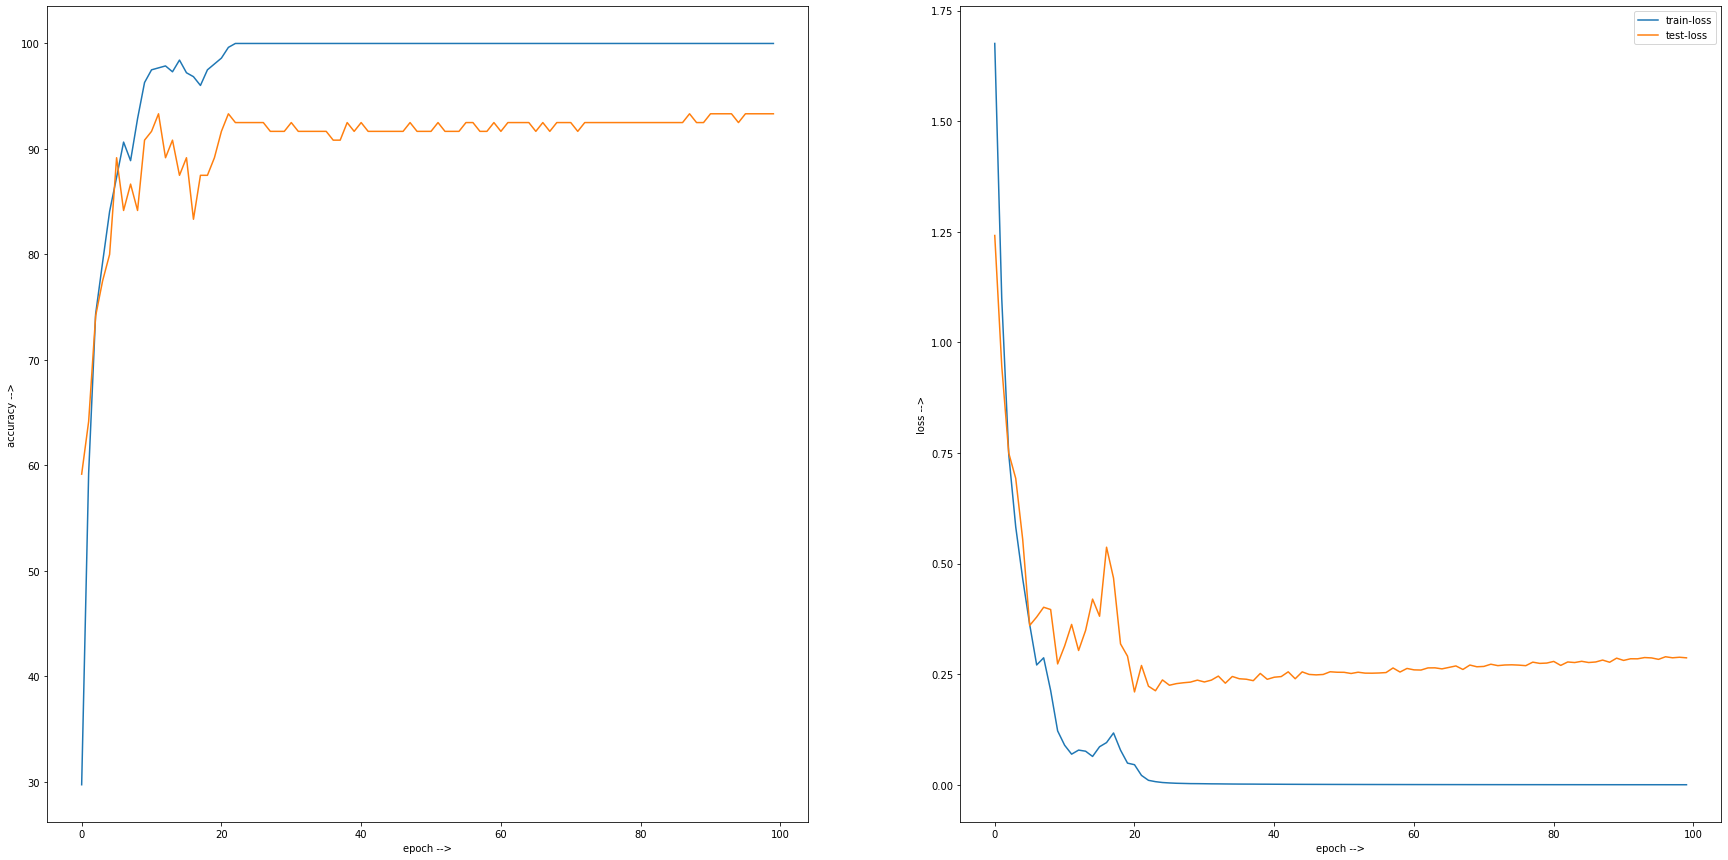

In [7]:
model, train_losses, train_accuracies, test_losses, test_accuracies = learn_model(
    train_data=train_data, test_data=test_data, model=model, 
    learning_rate=9e-3, beta1=0.9, beta2=0.999, epsilon=1e-08, 
    num_epochs=100, batch_size=64)
test_loss, test_accuracy = evaluate_model(model=model, test_data=test_data, 
    batch_size=64, loss_func=nn.NLLLoss(reduction='mean'))
print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

visualize_training(train_accuracies=train_accuracies, train_losses=train_losses,
    test_accuracies=test_accuracies, test_losses=test_losses)